In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
import gc
from datetime import datetime
from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
import seaborn as sns
import warnings

pd.set_option('float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

# 导入数据

In [2]:
train_base = pd.read_csv("./比赛数据/train_X.csv")
train_y = pd.read_csv("./比赛数据/train_y.csv")
test_a_base = pd.read_csv("./比赛数据/test_X.csv")

合并训练集测试集以便后续对整个数据特征的分析

In [3]:
train_base = train_base.merge(train_y, on = 'ID', how = 'left')
data = pd.concat([train_base,test_a_base],axis = 0).reset_index(drop=True)

查看data的详细信息，发现其所有特征都为数值型特征，且缺失值较少

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10327 entries, 0 to 10326
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             10327 non-null  int64  
 1   流动比率           10294 non-null  float64
 2   资产负债率          10316 non-null  float64
 3   销售毛利率          10265 non-null  float64
 4   净资产收益率         9986 non-null   float64
 5   投入资本回报率        10258 non-null  float64
 6   总资产报酬率         10268 non-null  float64
 7   应收款周转率         10217 non-null  float64
 8   营业收入           10305 non-null  float64
 9   所得税            10220 non-null  float64
 10  销售额            10267 non-null  float64
 11  经营活动产生的现金流量净额  10316 non-null  float64
 12  净利润            10316 non-null  float64
 13  资产总计           10316 non-null  float64
 14  负债合计           10316 non-null  float64
 15  所有者权益合计        10316 non-null  float64
 16  label          6951 non-null   float64
dtypes: float64(16), int64(1)
memory usage: 1.3 MB


In [5]:
# 查看数据特征缺失比例
data.apply(lambda x: x.isnull().sum()/len(x))

ID              0.000
流动比率            0.003
资产负债率           0.001
销售毛利率           0.006
净资产收益率          0.033
投入资本回报率         0.007
总资产报酬率          0.006
应收款周转率          0.011
营业收入            0.002
所得税             0.010
销售额             0.006
经营活动产生的现金流量净额   0.001
净利润             0.001
资产总计            0.001
负债合计            0.001
所有者权益合计         0.001
label           0.327
dtype: float64

经过观察发现，存在11行数据所有的特征都为空值，并且标签为0，这对后续的模型判断有影响，所以将这些全为空值的数据删去

In [6]:
data.loc[np.where(data["净利润"].isnull())[0], :]

,ID,流动比率,资产负债率,销售毛利率,净资产收益率,投入资本回报率,总资产报酬率,应收款周转率,营业收入,所得税,销售额,经营活动产生的现金流量净额,净利润,资产总计,负债合计,所有者权益合计,label
515,515,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000
908,908,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000
1536,1536,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000
2923,2923,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000
3336,3336,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000
4911,4911,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000
5098,5098,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000
5481,5481,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000
5552,5552,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000
5867,5867,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000


In [7]:
# 删去无用信息行
delete_idx = np.where(data["净利润"].isnull())[0]
data.drop(delete_idx, inplace=True, axis = 0)
data = data.reset_index(drop=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10316 entries, 0 to 10315
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             10316 non-null  int64  
 1   流动比率           10294 non-null  float64
 2   资产负债率          10316 non-null  float64
 3   销售毛利率          10265 non-null  float64
 4   净资产收益率         9986 non-null   float64
 5   投入资本回报率        10258 non-null  float64
 6   总资产报酬率         10268 non-null  float64
 7   应收款周转率         10217 non-null  float64
 8   营业收入           10305 non-null  float64
 9   所得税            10220 non-null  float64
 10  销售额            10267 non-null  float64
 11  经营活动产生的现金流量净额  10316 non-null  float64
 12  净利润            10316 non-null  float64
 13  资产总计           10316 non-null  float64
 14  负债合计           10316 non-null  float64
 15  所有者权益合计        10316 non-null  float64
 16  label          6940 non-null   float64
dtypes: float64(16), int64(1)
memory usage: 1.3 MB


最后我们可以发现净利润、资产总计、负债总计、所有者权益合计、资产负债率不存在缺失值了

从下面的结果中可以看到标签的样本比例是严重失衡的

In [9]:
train_base['label'].value_counts(normalize=True)

0   0.996
1   0.004
Name: label, dtype: float64

# 特征处理以及特征工程

首先基于对特征的业务理解，所有者权益合计 = 资产总计 - 负债总计，所有者权益合计与资产总计和负债总计有较强的相关性，所以首先去掉所有者权益这个特征。其次对于净资产收益率，净资产收益率=净利润/净资产，该指标体现了自有资本获得净收益的能力，但是对于净利润为负的情况，此时净资产收益率就属于无法用于判断企业受益好坏的指标，因此将净资产收益率也删掉。

In [10]:
maps = {'流动比率':'col_1'
        ,'资产负债率':'col_2'
        , '销售毛利率':'col_3'
        ,'净资产收益率':'col_4'
        , '投入资本回报率':'col_5'
        , '总资产报酬率':'col_6'
        , '应收款周转率':'col_7'
        , '营业收入':'col_8'
        , '所得税':'col_9'
        , '销售额':'col_10'
        , '经营活动产生的现金流量净额':'col_11'
        , '净利润':'col_12'
        , '资产总计':'col_13'
        , '负债合计':'col_14'
        , '所有者权益合计':'col_15'}
data = data.rename(columns = maps)

新特征：col_16。这是本次比赛方案的一个创新点，观察所得税以及净利润这两个特征，能够发现当净利润为负的情况下，所得税为正，以及当净利润为正的情况下，净利润为正的情况。这是由于所得税可能还会受到上一年顺延所得税的影响。经过查询，一般企业的所得税率为25%， 净利润为利润 - 当年所交所得税的值，因此我们用所得税 - 净利润 * 1/3 近似构造了上一年的顺延所得税，能够一定程度体现上一年企业的营收情况。

In [11]:
# 构建新特征
data["col_16"] = data["col_9"] - data["col_12"] * 1/3

下面是对验证集和训练集特征分布的分析

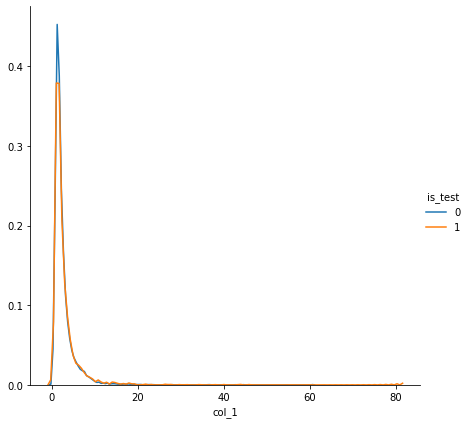

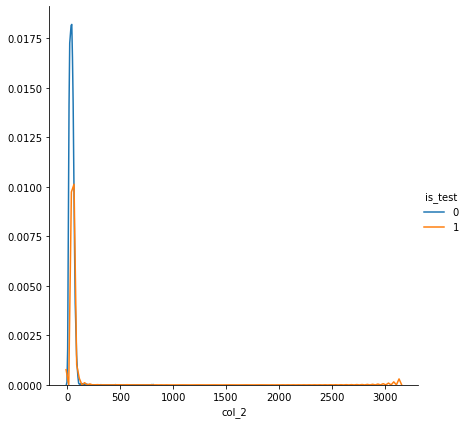

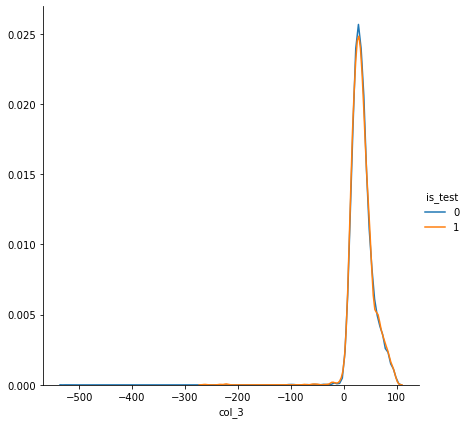

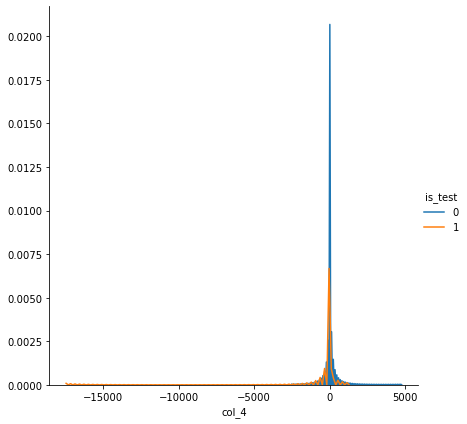

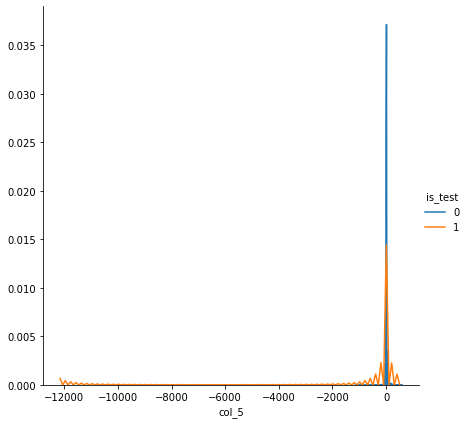

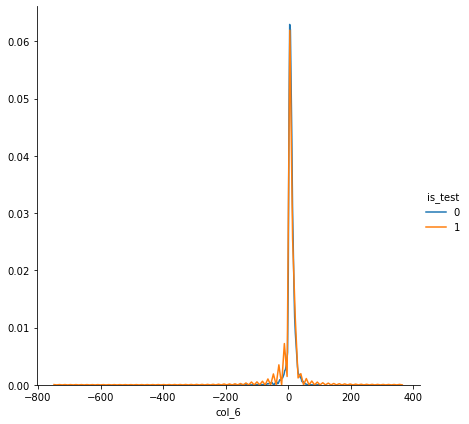

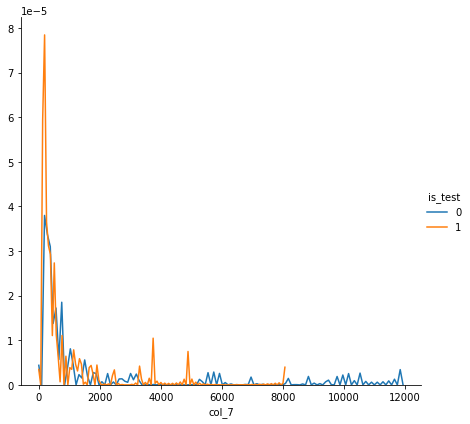

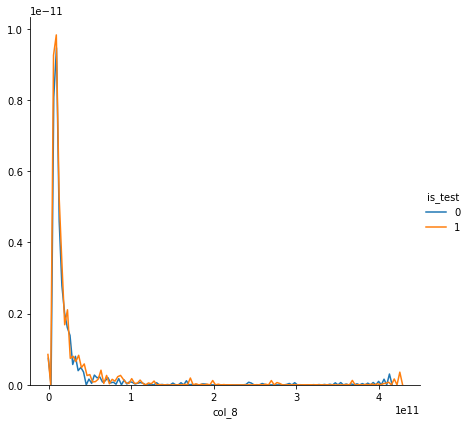

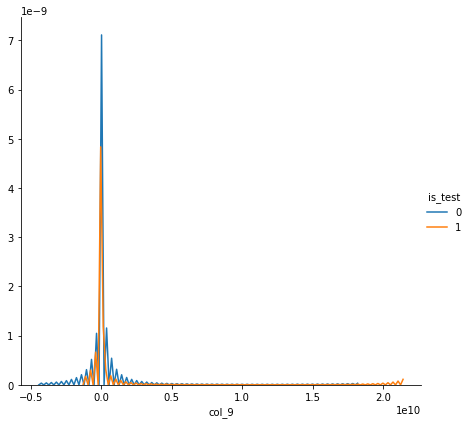

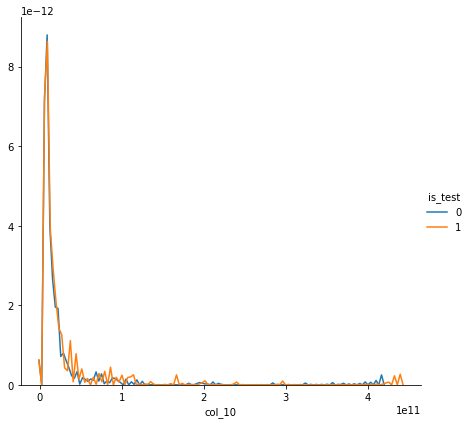

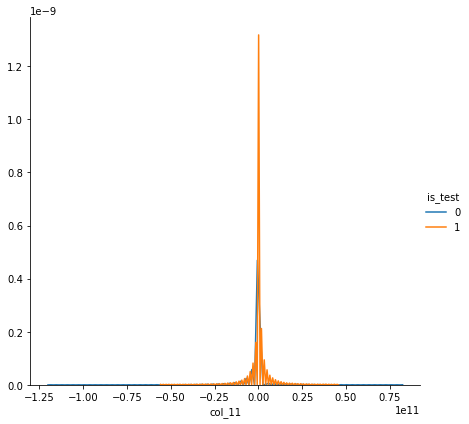

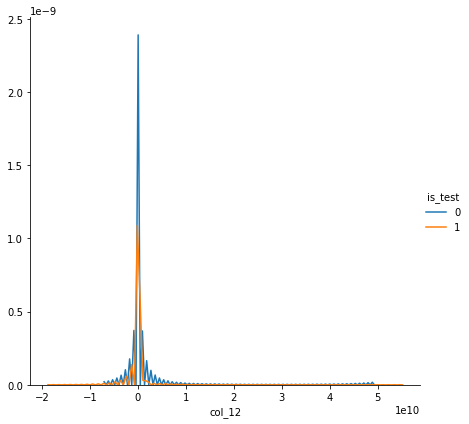

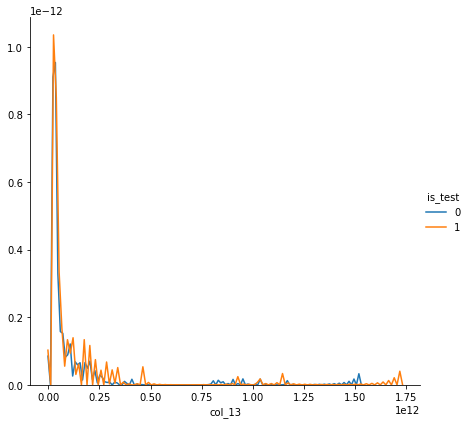

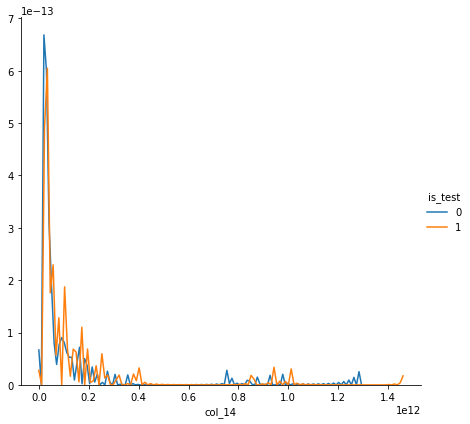

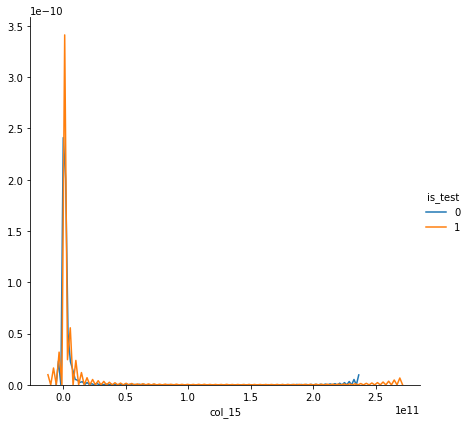

In [12]:
# 对验证集和测试集特征分布分析
data['is_test'] = data['label'].isnull().astype(int)
for feat in data.columns[1:16]:
    sns.FacetGrid(data, hue="is_test", size=6).map(sns.kdeplot, "%s"%feat).add_legend()

可以观察到基本上所有特征在特征集和测试集中基本是符合相同的分布的，但是由于企业体量的不同，净利润、资产总计、负债总计等非比值特征上存在十分陡峭的分布，后续也有尝试对这些特征做消除量纲化的手段，并且能在线下取得较好的效果，但是线上的分数却降低了，因此在本方案中舍弃了对非比值型特征去量纲化的做法。

后续通过将特征代入初步的lightgbm模型，凭借特征的重要度以及线上的分数进行筛选。

In [13]:
data.head()

,ID,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,label,col_16,is_test
0,0,0.558,55.315,25.261,1.956,2.186,2.483,3.315,784513668.580,9951614.160,600698130.360,61574140.560,21266971.830,3085869728.980,1706939175.850,1378930553.130,0.000,2862623.550,0
1,1,1.972,46.411,28.646,16.820,15.035,11.957,3.473,183422913.010,3605181.390,295356958.200,16510387.190,25075046.430,276744045.250,128439174.230,148304871.020,0.000,-4753167.420,0
2,2,1.900,53.954,34.459,nan,-13.525,-11.179,10.499,306851472.600,nan,321198072.000,21104877.460,-44685247.180,399717434.740,215662315.040,184055119.700,0.000,nan,0
3,3,4.871,17.440,46.867,21.608,19.925,18.274,10.938,305343811.830,6921549.790,292685434.990,-60763544.960,46317238.000,362933660.170,63296006.290,299637653.880,0.000,-8517529.543,0
4,4,1.295,67.844,13.489,10.850,9.761,5.865,2.105,4625372697.910,30281297.370,3168371546.090,-279012332.170,170848625.080,5307375448.740,3600743676.820,1706631771.920,0.000,-26668244.323,0


由于样本的严重失衡，正样本量太小，并且训练数据少，我用lightgbm模型对数据进行了初步的运行以后发现，尽管在线下的表现十分好，但是在线上的表现十分挣扎，因此只能根据线上的分数来不断调整数据的特征选择，最后选择特征['col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_16']。

# 构建训练集和测试集

In [14]:
# 分离训练集和测试集
drop_cols = ['ID','label','col_1', 'col_3', "col_4", "col_7", "col_9", "col_15", 'is_test']
unique_1_cols = []
for col in data.columns:
    if data[col].nunique() < 2:
        unique_1_cols.append(col)

In [15]:
test_df = data[data["label"].isnull() == True].copy().reset_index(drop=True)
train_df = data[~data["label"].isnull() == True].copy().reset_index(drop=True)
feature_name = [i for i in train_df.columns if i not in drop_cols+unique_1_cols]
X_train = train_df[feature_name].reset_index(drop=True)
X_test = test_df[feature_name].reset_index(drop=True)
y = train_df['label'].reset_index(drop=True)
print(feature_name)
print(len(feature_name))

['col_2', 'col_5', 'col_6', 'col_8', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_16']
10


# 代入模型

本方案选择了lightgbm模型，其中种子为1时线上分数为0.9622，种子为9时线上分数为0.9644。LightGBM是轻量级（Light）的梯度提升机器（GBM）,是GBDT模型的另一个进化版本。它延续了 XGBoost 的那一套集成学习的方式，相对于xgboost， 具有训练速度快和内存占用率低的特点。

对训练集采取了五折交叉验证的方法，在每一轮中以其中一折为验证集，另外四折作为训练集进行训练，设置early_stopping_round以达到在验证集上最好的效果，然后通过在验证集上表现最好的迭代次数进行在测试集上的预测，得到测试集每个样本为正样本的概率，最后会得到5次对测试集的预测分数，取平均即得到测试集最后的概率预测。

由于评价的标准选择的为auc，所以我们不需要再去在模型调整正负样本的比例，并且样本的预测概率大小并不影响auc的大小，影响auc大小的是样本的预测概率的排名情况，因此我们选择较小的learning_rate进行模型学习。最终的结果也不能单纯以0.5为概率值阈值去划分，需要人为去界定。

在得到lightgbm1（种子1）和lightgbm2（种子9）以后，通过不断调整选择了分别以3/4和1/4的比例进行线性的模型融合，得到最终我们的模型。

In [16]:
seeds = [1, 1, 1, 9]
num_model_seed = 4
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
parameters = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 55,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 2023,
    'bagging_seed': 1,
    'feature_fraction_seed': 7,
    'min_data_in_leaf': 10,
    'verbose': -1, 
    'n_jobs':4,
}
fold = 5
for model_seed in range(num_model_seed):
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(test_x, label=test_y)
        lgb_model = lgb.train(
            parameters,
            dtrain,
            num_boost_round=10000,
            valid_sets=[dval],
            early_stopping_rounds=200,
            verbose_eval=100,
        )
        oof_cat[test_index] += lgb_model.predict(test_x,num_iteration=lgb_model.best_iteration)
        prediction_cat += lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration) / fold
        feat_imp_df['imp'] += lgb_model.feature_importance()

        del train_x
        del test_x
        del train_y
        del test_y
        del lgb_model
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
gc.collect()

1 --------------------------------------------------------------------------------------------
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.606941
[200]	valid_0's auc: 0.763991
Early stopping, best iteration is:
[12]	valid_0's auc: 0.800506
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.949964
[200]	valid_0's auc: 0.972379
Early stopping, best iteration is:
[2]	valid_0's auc: 0.985322
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.811424
[200]	valid_0's auc: 0.915691
[300]	valid_0's auc: 0.898337
Early stopping, best iteration is:
[176]	valid_0's auc: 0.918872
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.638901
[200]	valid_0's auc: 0.773825
Early stopping, best iteration is:
[8]	valid_0's auc: 0.863268
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.558008
[200]	valid_0's auc: 0.529848
Early stop

43994

In [17]:
# 查看在训练集上的auc分数
train_auc = roc_auc_score(y,oof)
print("AUC:",train_auc)

AUC: 0.7467207004739548


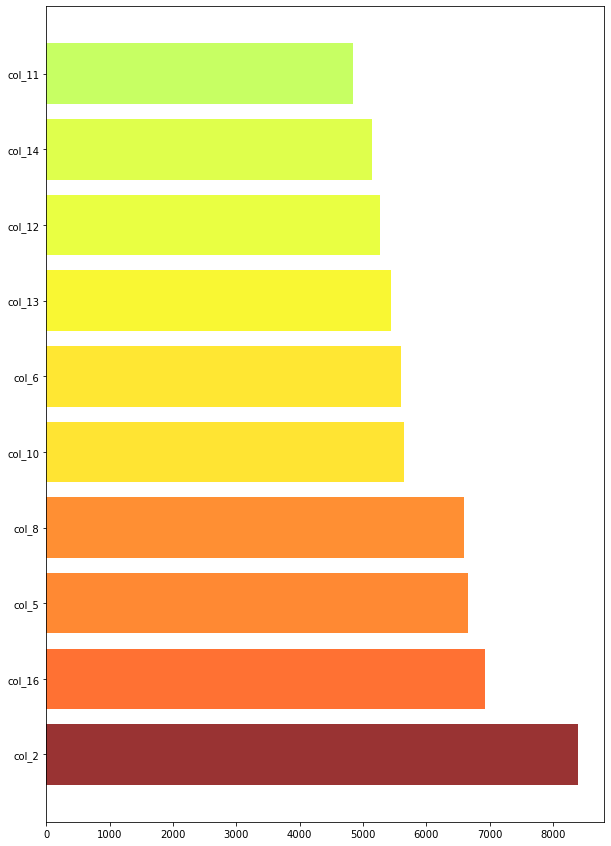

In [18]:
#查看模型的特征重要性
import matplotlib.pyplot as plt 
from matplotlib import cm

score = feat_imp_df.sort_values(['imp'], ascending=False)
temp = pd.DataFrame()
temp = score[:60]
color = cm.jet(temp['imp']/temp['imp'].max())
plt.figure(figsize=(10, 15))
plt.barh(temp['feats'],temp['imp'],height =0.8,color=color,alpha=0.8)
plt.show()

可以看到特征重要性由大到小排列为：资产负债率＞企业上一年所得税＞投入资本回报率＞营业收入＞销售额＞总资产报酬率＞资产总计＞净利润＞负债总计＞经营活动产生的现金流量净额

# 测试集上表现

In [19]:
test2 = test_df.copy()
test2['y_score'] = prediction
# test2[['ID','y_score']].to_csv("./结果提交/4.21/submit_{}.csv".format(round(train_auc,5)),index=False)

In [20]:
prediction_df = test2[['ID','y_score']]

通过下面的输出可以看到排名前十的具有退市风险的企业ID

In [21]:
prediction_df.sort_values('y_score', ascending=False)[:10]

,ID,y_score
1171,1171,0.223
2825,2825,0.223
2549,2549,0.217
133,133,0.190
2897,2897,0.181
2249,2249,0.179
2116,2116,0.165
839,839,0.165
1288,1288,0.135
360,360,0.122


下面我们选择分数最高的1171来进行分析

In [22]:
analysis = pd.DataFrame(X_test.iloc[1171, :]).T
analysis.rename(columns = {'col_2': '资产负债率'
                            , 'col_5': '投入资本回报率'
                            , 'col_6': '总资产报酬率'
                            , 'col_8': '营业收入'
                            , 'col_10': '销售额'
                            , 'col_11': '经营活动产生的现金流量净额'
                            , 'col_12': '净利润'
                            , 'col_13': '资产总计'
                            , 'col_14': '负债合计'
                            , 'col_16': '上一年所得税'}
                          , inplace = True)

In [23]:
analysis.T

,1171
资产负债率,499.524
投入资本回报率,-442.449
总资产报酬率,-117.024
营业收入,313536278.800
销售额,224185741.000
经营活动产生的现金流量净额,14389356.460
净利润,-12325768619.000
资产总计,2577457154.000
负债合计,12875029679.000
上一年所得税,4123278456.607


1、首先可以看到特征重要性最高的资产负债率极高。资产负债率=总负债/总资产，如果资产负债比率达到100%或超过100%说明公司已经没有净资产或资不抵债，因此该指标说明该企业有极大的退市风险。

2、排名第二的上一年所得税为正，说明其在上一年倾向于有比较好的利润的，结合今年净利润为负，投入资本回报率、总资产报酬率为负，并且负的绝对值很大，可以说明该企业在今年应该有着重大的亏损，因此退市的风险很大。投入资本回报率是用来评估一个企业或其事业部门历史绩效的指标。它决定着企业的未来价值，它也是对公司进行评估的一个最主要的指标。而总资产报酬率表示企业包括净资产和负债在内的全部资产的总体获利能力，用以评价企业运用全部资产的总体获利能力，是评价企业资产运营效益的重要指标。

3、还可以从营业收入和销售额看到，这两个指标为正，也就是该企业明明存在着收入，但是净利润依旧是大额负值，可以猜测该企业背负债务过多，而营收能力并没达到相应体量的要求，因此导致有退市的风险。